In [1]:
%matplotlib inline

import random
import pickle
import chromadb
import numpy as np
from pprint import pprint
from tqdm.auto import tqdm
import sys
from matplotlib import pyplot as plt
import networkx as nx
import json
from pyvis.network import Network

sys.path.append("../")
from utils.parse_arxiv import *
from make_vectordb import get_embedding_model

[nltk_data] Downloading package punkt to /home/zyang37/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# create a random adjacency matrix (graph), user can also specify their numbers of random edges
def create_random_adjacency_matrix(n, num_edges=None):
    adj = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < 0.5:
                adj[i, j] = 1
                adj[j, i] = 1
    if num_edges is not None:
        edges = np.argwhere(adj == 1)
        if len(edges) > num_edges:
            edges = random.sample(list(edges), num_edges)
            adj = np.zeros((n, n))
            for i, j in edges:
                adj[i, j] = 1
                adj[j, i] = 1
    return adj

# a func take in an adjacency matrix and return eigenvalues and eigenvectors
def get_eigen(adj):
    eigenvalues, eigenvectors = np.linalg.eig(adj)
    return eigenvalues, eigenvectors

/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


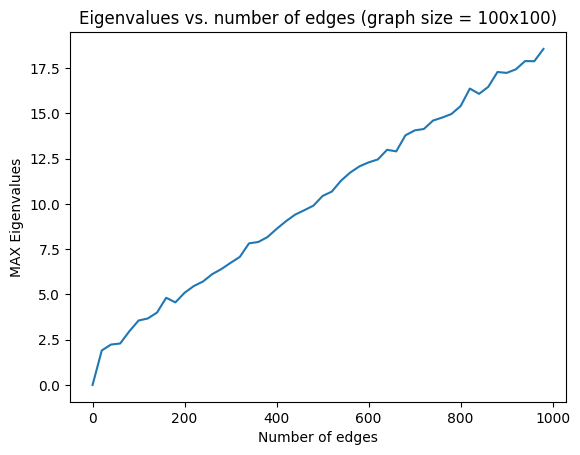

In [3]:
g = create_random_adjacency_matrix(10, 10)
# print(g)
# print()
eigenvalues, eigenvectors = get_eigen(g)
# print(eigenvalues.sum())
# print(eigenvectors)

# make a plot of eigenvalues vs. number of edges (0 to 100, step 10)
n = 100
num_edges = []
eigenvalues_sum = []
for ne in range(0, 1000, 20):
    num_edges.append(ne)
    # print(num_edges)
    g = create_random_adjacency_matrix(n, ne)
    eigenvalues, eigenvectors = get_eigen(g)
    eigenvalues_sum.append(eigenvalues.max())
    # print(eigenvalues.sum())

plt.plot(num_edges, eigenvalues_sum)
plt.xlabel('Number of edges')
plt.ylabel('MAX Eigenvalues')
plt.title('Eigenvalues vs. number of edges (graph size = {}x{})'.format(n,n))
plt.show()

In [4]:
 # load pickle
g_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))
g_data.data_dict['id_1009.5145']

{'author:RaymondH.Y.Louie',
 'author:YonghuiLi',
 'author:andBrankaVucetic',
 'category:cs.IT',
 'category:math.IT',
 'journal:IEEE Transactions on Vehicular Technology, 2010',
 'year:2016'}

In [5]:
G = nx.Graph()
G.add_nodes_from([(2, {"color": "red"}), (3, {"color": "blue"}), (4, {"color": "green"})])
colors = [G.nodes[n]['color'] for n in G.nodes]
print(colors)

# nx.draw(G, with_labels=True, node_color=colors)

['red', 'blue', 'green']


In [6]:
# G.keyword_dict.keys()

# a func take in a list and return all combinations of 2 elements, do not use list comprehension
def get_pair_combinations(l):
    result = []
    for i in range(len(l)):
        # try: 
        #     result.append((l[i], l[i+1]))
        # except:
        #     result.append((l[i], l[0]))
        for j in range(i+1, len(l)):
            result.append((l[i], l[j]))
    return result

In [7]:
class MetadataGraph:
    def __init__(self):
        self.G = nx.Graph()
        self.metadata_nodes = []

    def update_one(self, metadata_set):
        self.add_data_nodes(metadata_set)
        self.connect_edges(metadata_set)

    def add_data_nodes(self, metadata_set):
        metadata_list = list(metadata_set)
        # color hex code random generator
        random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

        # construct a list of tuples, each tuple is a node and its attributes: (node, {attr1: val1, attr2: val2, ...})
        metadata_nodes_with_attrs = []
        for md in metadata_list:
            metadata_nodes_with_attrs.append((md, {"color": random_color}))

        self.G.add_nodes_from(metadata_nodes_with_attrs)
        self.metadata_nodes.extend(metadata_list)

    def connect_edges(self, metadata_set):
        metadata_list = list(metadata_set)
        edge_list = get_pair_combinations(metadata_list)
        self.G.add_edges_from(edge_list)

    def get_adjacency_matrix(self):
        return nx.adjacency_matrix(self.G).todense()
    
    def get_laplacian_matrix(self, normalized=False):
        if normalized:
            return nx.normalized_laplacian_matrix(self.G).todense()
        
        return nx.laplacian_matrix(self.G).todense()
    
    def draw(self, with_labels=False, node_size=15, alpha=0.85, subplot_ax=None):
        colors = [self.G.nodes[n]['color'] for n in self.G.nodes]
        nx.draw(self.G, with_labels=with_labels, node_color=colors, node_size=node_size, pos=nx.spring_layout(self.G), alpha=alpha, ax=subplot_ax)

# Color scheme

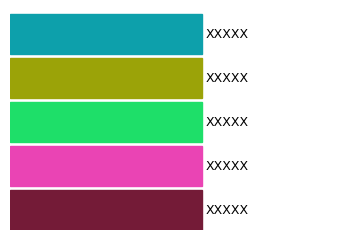

In [8]:
def color_scheme_gen(num):
    '''
    Generate a list of random color hex codes, each code is a string. 
    '''
    color_list = []
    for i in range(num):
        color_list.append("#{:06x}".format(random.randint(0, 0xFFFFFF)))
    return color_list

def plot_color_scheme(color_list, text_list=None):
    '''
    Plot the color scheme, each color is a hex code string. horizontal color bars with text after each bar.

    Args:
        - color_list: list of color hex codes
        - text_list: list of text strings, each string is the name of the color
    '''
    height = 0.9
    width = 0.6

    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    for i, c in enumerate(color_list):
        ax.add_patch(plt.Rectangle((0, i), width, height, color=c))
    
    if text_list is not None:
        for i, t in enumerate(text_list):
            ax.text(width*1.02, i+0.5*height, t, ha='left', va='center', fontsize=9, color='black')
        
    ax.set_ylim(0, len(color_list))
    # ax.set_xlim(0, 1)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


num = 5
color_list = color_scheme_gen(num)
text_list = ["XXXXX"] * num
plot_color_scheme(color_list, text_list)

In [9]:
def get_cat_from_keyword(keyword):
    return keyword.split(':')[0]

keys = random.sample(list(g_data.data_dict.keys()), 1)
print(g_data.data_dict[keys[0]])

{'journal:IEEE Transactions on Automatic Control, 2020', 'year:2020', 'author:SeanWeerakkody', 'category:cs.SY', 'author:PaulGriffioen', 'author:andBrunoSinopoli'}


add id_2202.12524


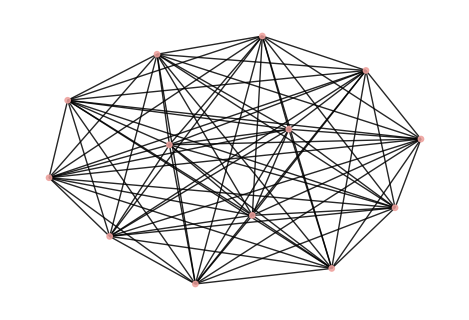

add id_2102.02873


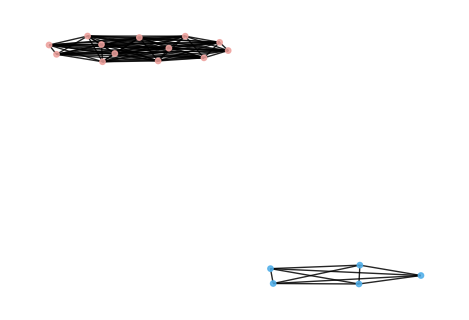

add id_2008.10494


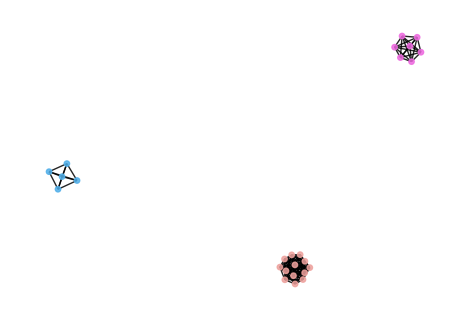

add id_2111.04156


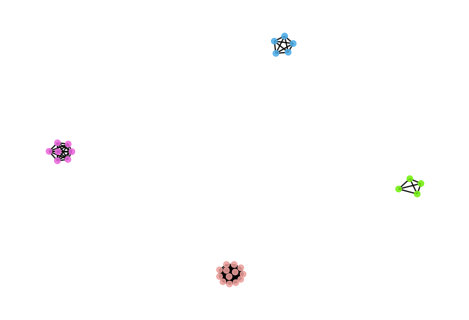

add id_2008.0519


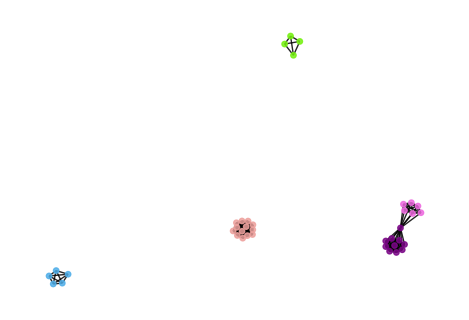

add id_2011.10136


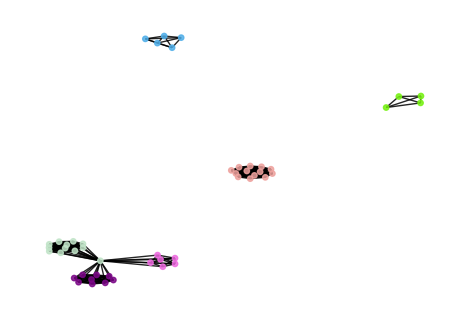

add id_2012.05078


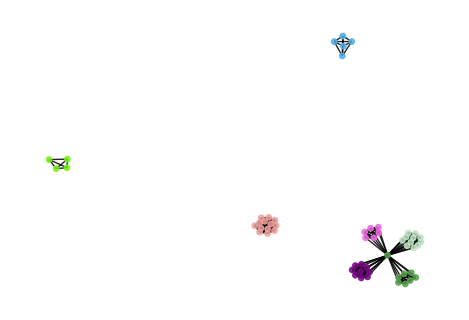

add id_2008.10434


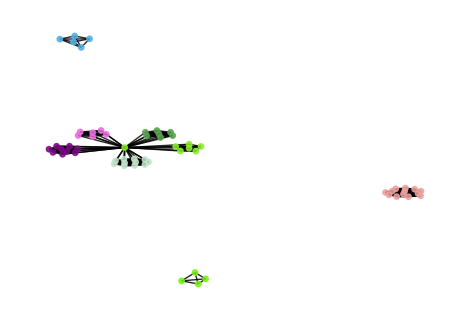

add id_1502.05044


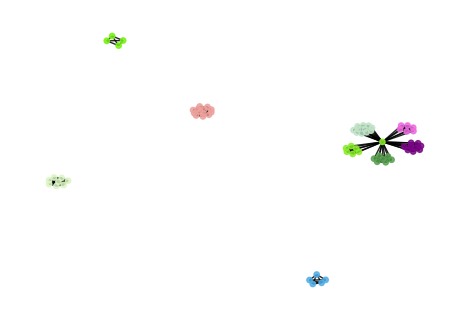

add id_1710.09745


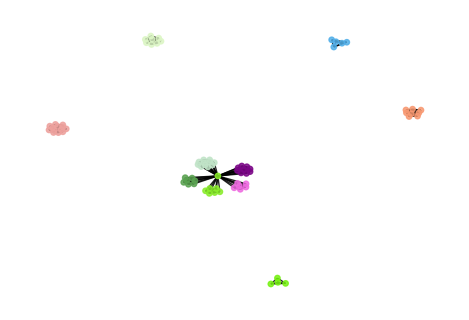

nx.html


In [10]:
# random pick keys 
keys = random.sample(list(g_data.data_dict.keys()), 10)

# test the class
mg = MetadataGraph()

for k in keys:
    print("add {}".format(k))
    mg.update_one(g_data.data_dict[k])
    plt.figure(figsize=(4.5, 3))
    mg.draw()
    plt.show()
    
nt = Network('700px', '900px', notebook=True)
nt.from_nx(mg.G)
nt.toggle_physics(True)
nt.show('nx.html')

In [11]:
# pprint(mg.G.edges())

In [12]:
# g_data.data_dict['id_2308.02657']

In [13]:
# mg.G.nodes['category:cs.IT']

# ChromaDB

In [14]:
# chroma_client = chromadb.PersistentClient(path="../data/chroma_dbs/")
# chroma_client.list_collections()

In [15]:
G_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))

# read json result file
results = json.load(open('../data/arxiv/arxiv_workloads/res/k100_gk20_pn50_n20.json', 'r'))
results['1'].keys()

dict_keys(['index', 'paper_id', 'query', 'arxiv_title', 'arxiv_abstract', 'hybrid', 'weighted_hybrid'])

In [16]:
def remove_id_from_list(id_list, id_to_remove):
    return [id for id in id_list if id != id_to_remove]

def random_paper_id_swap(id_list, id_pool, num, from_end=True, random_=None):
    '''
    Randomly swap paper ids in the id_list with ids in the id_pool (not in the id_list) without replacement.

    args:
        - id_list: list of paper ids
        - id_pool: list of paper ids (not in the id_list)
        - num: number of ids to swap
        - from_end: if True, swap ids from the end of the id_list, else from the beginning
        - random: if True, randomly remove id from id_list, will OVERRIDE from_end args (in development)
    '''
    if num > len(id_pool) or num==0:
        return id_list

    # randomly pick num of ids from id_pool
    swap_ids = random.sample(id_pool, num)

    if random_ is None:
        if from_end:
            # remove num of ids from the end of id_list
            id_list = id_list[:-num]
            id_list.extend(swap_ids)
        else:
            # remove num of ids from the beginning of id_list
            id_list = id_list[num:]
            id_list = swap_ids + id_list
    else:
        # randomly remove num ids from id_list, and insert swap_ids
        raise NotImplementedError
    
    return id_list

In [17]:
paper_id_pool = list(G_data.data_dict.keys())

In [45]:
sample_res = results['0']['arxiv_abstract']

good_recall_mg = MetadataGraph()
for k in tqdm(sample_res):
    good_recall_mg.update_one(g_data.data_dict[k])

  0%|          | 0/100 [00:00<?, ?it/s]

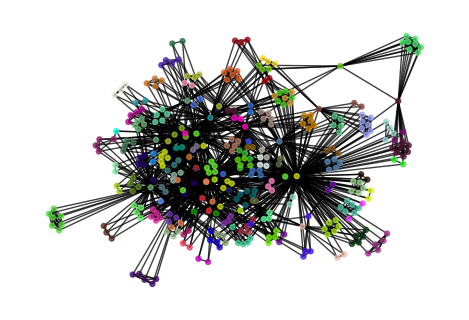

1.409964802648009


In [46]:
plt.figure(figsize=(4.5, 3))
good_recall_mg.draw(node_size=13, alpha=0.75)
plt.show()

# get eigenvalues for the laplacian matrix
eigenvalues, eigenvectors = get_eigen(good_recall_mg.get_laplacian_matrix(normalized=True))
print(eigenvalues.real.max())

In [47]:
# nt = Network('1000px', '1000px', notebook=True)
# nt.from_nx(good_recall_mg.G)
# nt.toggle_physics(True)
# nt.show('nx.html')

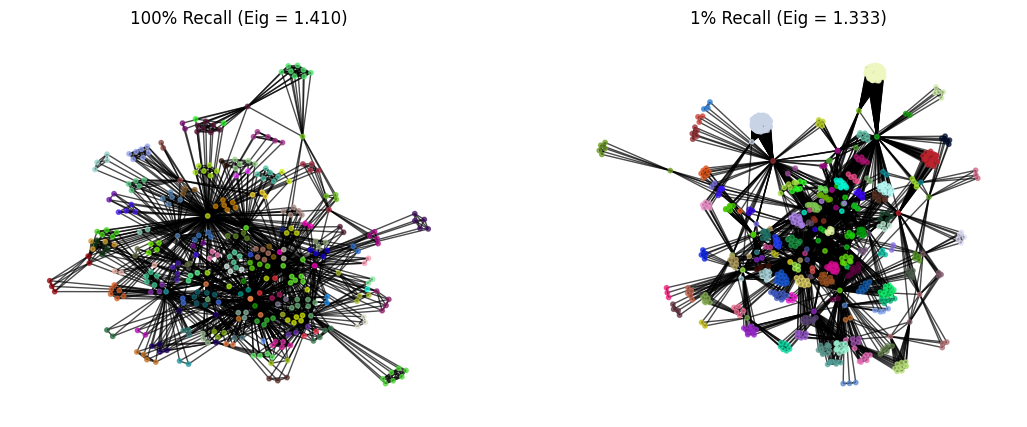

In [48]:
swapped_res = random_paper_id_swap(sample_res, remove_id_from_list(paper_id_pool, sample_res), 99, from_end=True)
bad_recall_mg = MetadataGraph()
for k in swapped_res:
    bad_recall_mg.update_one(g_data.data_dict[k])

bad_eigenvalues, bad_eigenvectors = get_eigen(bad_recall_mg.get_laplacian_matrix(normalized=True))

# plot good recall plot and bad recall plot side by side
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
good_recall_mg.draw(node_size=10, alpha=0.7, subplot_ax=ax[0])
bad_recall_mg.draw(node_size=10, alpha=0.7, subplot_ax=ax[1])
ax[0].set_title('100% Recall (Eig = {:.3f})'.format(eigenvalues.real.max()))
ax[1].set_title('1% Recall (Eig = {:.3f})'.format(bad_eigenvalues.real.max()))
plt.show()

In [49]:
recalls = []
numbers_of_edges = []
adjacency_eigenvalues = []
laplacian_eigenvalues = []

# given sample res
for num in tqdm(range(len(sample_res))):
    swapped_res = random_paper_id_swap(sample_res, remove_id_from_list(paper_id_pool, sample_res), num, from_end=True)
    mg = MetadataGraph()
    for k in swapped_res:
        mg.update_one(g_data.data_dict[k])

    numbers_of_edges.append(mg.G.number_of_edges())
    
    eigenvalues, _ = get_eigen(mg.get_adjacency_matrix())
    adjacency_eigenvalues.append(eigenvalues.real.max())

    eigenvalues, _ = get_eigen(mg.get_laplacian_matrix(normalized=True))
    laplacian_eigenvalues.append(eigenvalues.real.max())
    # eigenvalues = eigenvalues[eigenvalues > 0]
    # real_min_eigen = eigenvalues.real.min()
    # laplacian_eigenvalues.append(real_min_eigen)

    recalls.append( (len(sample_res) - num) / len(sample_res) )

  0%|          | 0/100 [00:00<?, ?it/s]

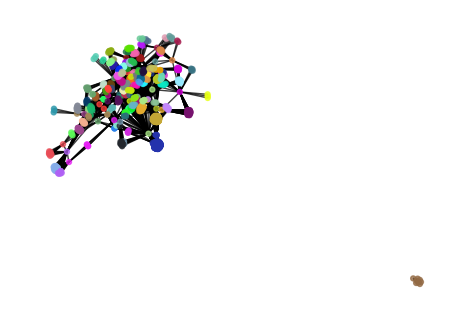

In [50]:
plt.figure(figsize=(4.5, 3))
mg.draw(node_size=13, alpha=0.75)
plt.show()

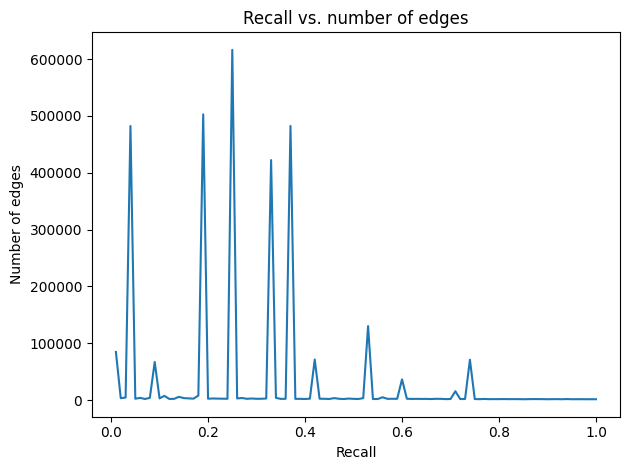

In [51]:
# plot recall vs. number of edges
plt.plot(recalls, numbers_of_edges)
plt.xlabel('Recall')
plt.ylabel('Number of edges')
plt.title('Recall vs. number of edges')
plt.tight_layout()
plt.show()

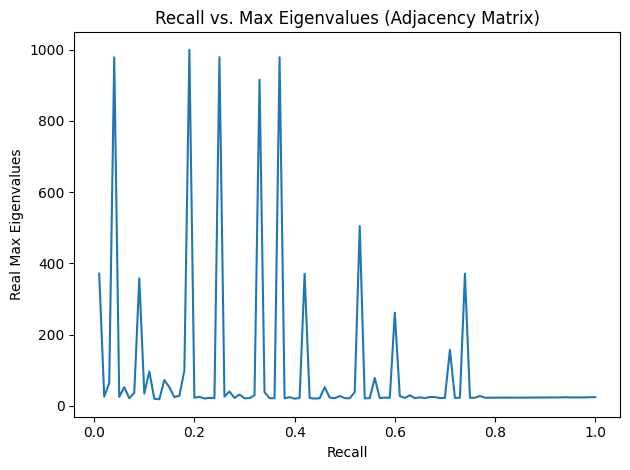

In [52]:
# plot
plt.plot(recalls, adjacency_eigenvalues)
plt.title('Recall vs. Max Eigenvalues (Adjacency Matrix)')
plt.xlabel('Recall')
plt.ylabel('Real Max Eigenvalues')
plt.tight_layout()
plt.show()

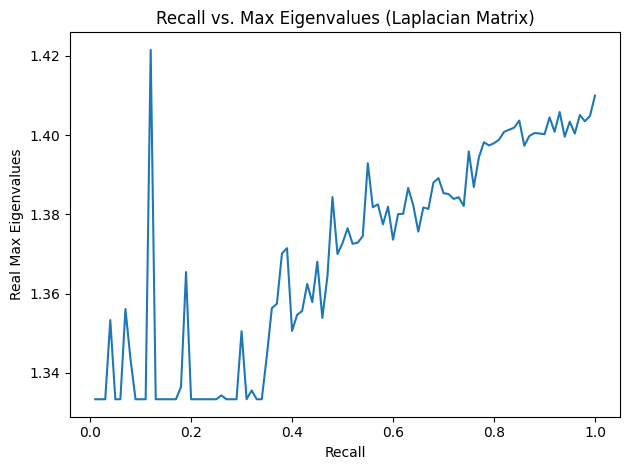

In [53]:
plt.plot(recalls, laplacian_eigenvalues)
plt.title('Recall vs. Max Eigenvalues (Laplacian Matrix)')
plt.xlabel('Recall')
plt.ylabel('Real Max Eigenvalues')
plt.tight_layout()
plt.show()

In [42]:
results['20']['query']

'find papers about < heavy hitters formulation generates solutions and tightly clustered objects and real video and household domains >'

In [54]:
results['0']['query']

'find papers about < weakly mixing representations and quantum groups and dimensional representations and trivial scaling group and matrix quantum groups >'

# Compute average for more queries

In [27]:
def get_eigens_from_results(sample_res, paper_id_pool):    
    recalls = []
    numbers_of_edges = []
    adjacency_eigenvalues = []
    laplacian_eigenvalues = []
    for num in range(len(sample_res)):
        swapped_res = random_paper_id_swap(sample_res, remove_id_from_list(paper_id_pool, sample_res), num, from_end=True)
        mg = MetadataGraph()
        for k in swapped_res:
            mg.update_one(g_data.data_dict[k])

        numbers_of_edges.append(mg.G.number_of_edges())
        
        eigenvalues, _ = get_eigen(mg.get_adjacency_matrix())
        adjacency_eigenvalues.append(eigenvalues.real.max())

        eigenvalues, _ = get_eigen(mg.get_laplacian_matrix(normalized=True))
        laplacian_eigenvalues.append(eigenvalues.real.max())
        # eigenvalues = eigenvalues[eigenvalues > 0]
        # real_min_eigen = eigenvalues.real.min()
        # laplacian_eigenvalues.append(real_min_eigen)
        recalls.append( (len(sample_res) - num) / len(sample_res) )
    return recalls, numbers_of_edges, adjacency_eigenvalues, laplacian_eigenvalues

In [28]:
G_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))

# read json result file
results = json.load(open('../data/arxiv/arxiv_workloads/res/k100_gk20_pn50_n20.json', 'r'))
paper_id_pool = list(G_data.data_dict.keys())

In [ ]:
# sample_res = results['0']['arxiv_abstract']
recalls_list = []
numbers_of_edges = []
adjacency_eigenvalues = []
laplacian_eigenvalues = []

for index, res_k in tqdm(enumerate(results.keys()), total=len(results.keys())):
    sample_res = results[res_k]['arxiv_abstract']

    recalls, edges, adj_eig, lap_eig = get_eigens_from_results(sample_res, paper_id_pool)
    recalls_list.append(recalls)
    numbers_of_edges.append(edges)
    adjacency_eigenvalues.append(adj_eig)
    laplacian_eigenvalues.append(lap_eig)

    # if index==3:
    #     break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
# compute avg 
recalls = np.array(recalls_list)
numbers_of_edges = np.array(numbers_of_edges)
adjacency_eigenvalues = np.array(adjacency_eigenvalues)
laplacian_eigenvalues = np.array(laplacian_eigenvalues)

avg_recalls = recalls.mean(axis=0)
avg_edges = numbers_of_edges.mean(axis=0)
avg_adj_eig = adjacency_eigenvalues.mean(axis=0)
avg_lap_eig = laplacian_eigenvalues.mean(axis=0)

In [57]:
numbers_of_edges.shape

(1000, 100)

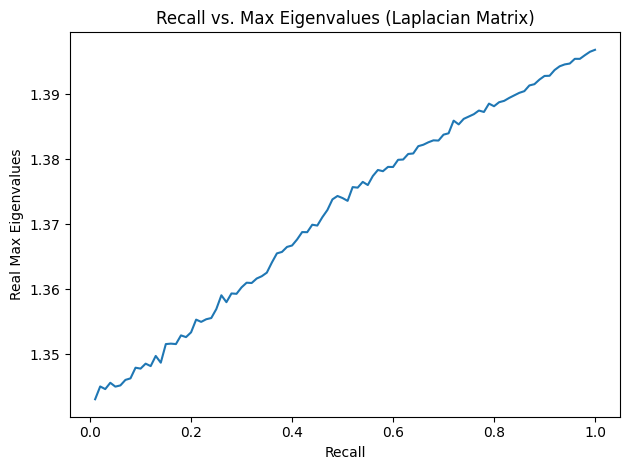

In [59]:
plt.plot(avg_recalls, avg_lap_eig)
plt.title('Recall vs. Max Eigenvalues (Laplacian Matrix)')
plt.xlabel('Recall')
plt.ylabel('Real Max Eigenvalues')
plt.tight_layout()
# plt.savefig("Laplacian_Eigen_k100_gk20_pn50_n20.png")
plt.show()

# Recall vs. Egien runtime

Keep adding element to list, will Egienvalue be increasing. 

Note: Direct comparison with graph that have different numbers of node. Need to normalixation. 

In [ ]:
def get_eigens_from_results_runtime(sample_res):    
    number_of_elements = []
    numbers_of_edges = []
    adjacency_eigenvalues = []
    laplacian_eigenvalues = []
    
    for num in range(len(sample_res)):
        partial_data_samples  = 
        
        mg = MetadataGraph()
        for k in swapped_res:
            mg.update_one(g_data.data_dict[k])

        numbers_of_edges.append(mg.G.number_of_edges())
        
        eigenvalues, _ = get_eigen(mg.get_adjacency_matrix())
        adjacency_eigenvalues.append(eigenvalues.real.max())

        eigenvalues, _ = get_eigen(mg.get_laplacian_matrix(normalized=True))
        laplacian_eigenvalues.append(eigenvalues.real.max())
        recalls.append( (len(sample_res) - num) / len(sample_res) )
        
    return recalls, numbers_of_edges, adjacency_eigenvalues, laplacian_eigenvalues